# 데이터 분석

### 최종 코드

In [1]:
# 함수 정리

---

### 연습용

In [2]:
import pandas as pd

In [3]:
temp_review_strlength = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")

In [5]:
review_strlist = temp_review_strlength["Review_Text"].to_list()
review_string = ''.join(str(s) for s in review_strlist)

In [6]:
review_string

'직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입니다 조금씩 일찍 입장시켜주시는 융통성도 좋아요 쪼금 아쉬운 건 의 외로 과일류 구색이 약하다는 거종류도 알차게 많고 다 맛있어요신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서비스 상태 좋고 직원 분들이 매우 친절하시고 어디에나 어느 곳이든 다 상주해 계셔서 호텔 서비스 이용하는데 매우 편했습니다 물론 5성급 호텔이라서 숙박비나 발레 파킹 비용이 비싼 편이지만 돈 쓰러 오는 곳인 만큼 가치 있어요창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 짜장면 도 삭면은 불어 있고 문어 숙회는 너무 안 익은 느낌 양 갈비 맛있었어요 딸기 달달 한라봉 새콤달콤 약 15분 정도 일찍 입장해서 좋았지만 모든 음식 코너에 긴 줄 디저트부터 시작했네요 직원 분들 서비스가 너무 좋아서 모든 게 커버되는 거 같아요항상 친절하시고 음식도 맛있네요분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩 스 시 모든 재료가 싱싱하고 맛있습니다 고기 디저트로 버 분들 여기 무조건 추천드립니다 만족한 저녁 식사였습니다부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시더라고요 다른 뷔페들보다 더 맛있다고 하셔서 뿌듯했습니다신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음식 퀄리티가 최상입니다 가 짓수도 많고요 디저트의 퀄리티도 남 다릅니다평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만 파크뷰만 한 곳이 없는 거 같기도 해요 덕분에 기 분 좋은 저녁 식사와 함께 즐거운 시간 보내고 왔습니다 메뉴 구성도 알차고 바로바로 내어주시는 음식 덕분에 역시 더 파크뷰네요 하고 말할 수 있네요네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집연말에 평일 디너를 어떻게든 다녀왔었습니다 사람이 많았지만 즐거웠고 구

---

1. 명사 분류하기
    - 시각화
2. 동사, 형용사 분류하기
    - 시각화

### 1. 명사

In [7]:
# 1. 명사 분류하기
# from konlpy.tag import Okt
# okt = Okt()

# def okt_noun_extractor(text):
#     return okt.nouns(text)

In [30]:
# kiwi 명사 추출 함수
from kiwipiepy import Kiwi
kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [31]:
# review_nouns = okt_noun_extractor(review_string)
review_nouns = kiwi_noun_extractor(review_string)

In [32]:
# - 명사 시각화 하기
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    plt.show()

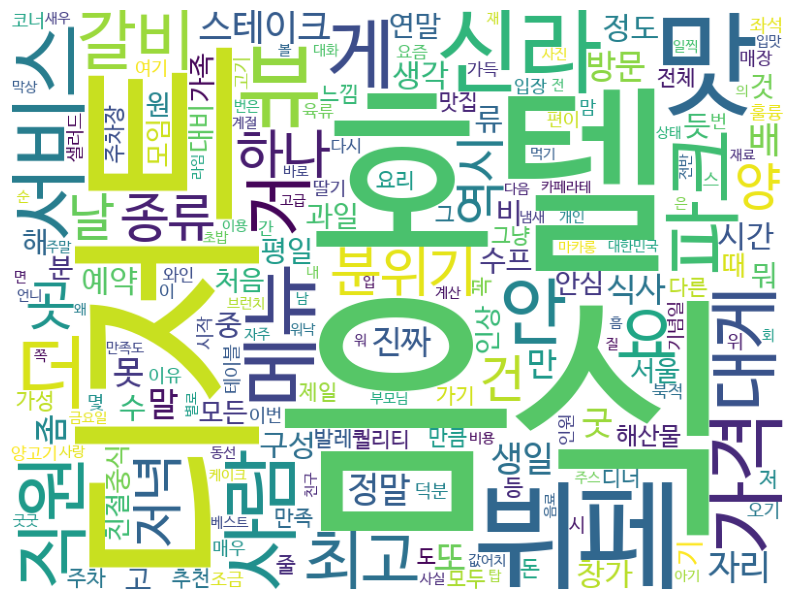

In [11]:
wordcloud_noun(review_nouns)

- 위의 명사를 통해 디저트, 호텔, 음식에 대한 키워드가 많이 나왔고, 메뉴, 사람, 가격등의 단어가 분포가 그다음으로 많음.

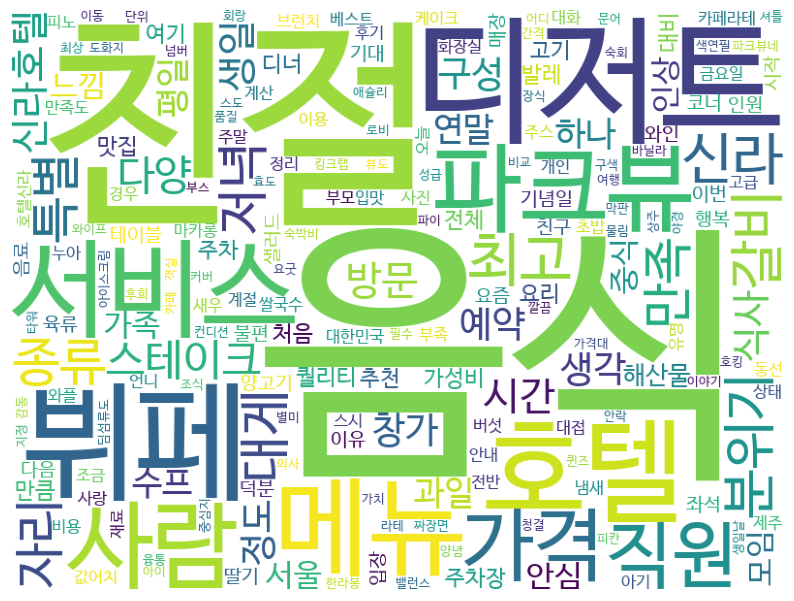

In [33]:
wordcloud_noun(review_nouns)

- 위의 워드클라우드를 통해 `친절`, `음식` 등의 단어가 제일 많이 분포되어 있고 그뒤로 `서비스`, `디저트`,`분위기`등의 단어들이 분포가 된다.

### 2. 동사 / 형용사

In [18]:
# 동사 / 형용사 분류하기

def okt_adj_verb_extractor(text):
    results = []
    result = okt.pos(text)
    
    for token, pos in result:
        if len(token) != 1 and pos.startswith('Adj'): #or pos.startswith('Verb'):
            results.append(token)
    return results

In [22]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    return results

In [34]:
review_adj_verb_okt = okt_adj_verb_extractor(review_string)
review_adj_verb_temp = kiwi_verb_adj_extractor(review_string)
review_adj_verb = list(map(lambda x : x + '다',review_adj_verb_temp))

In [20]:
# review_adj_verb

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    plt.show()

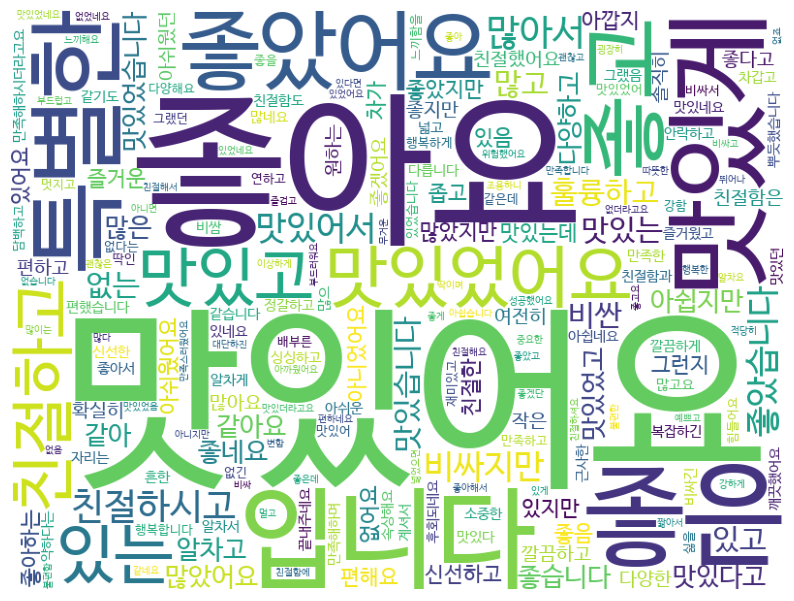

In [35]:
wordcloud_verb_adj(review_adj_verb_okt)

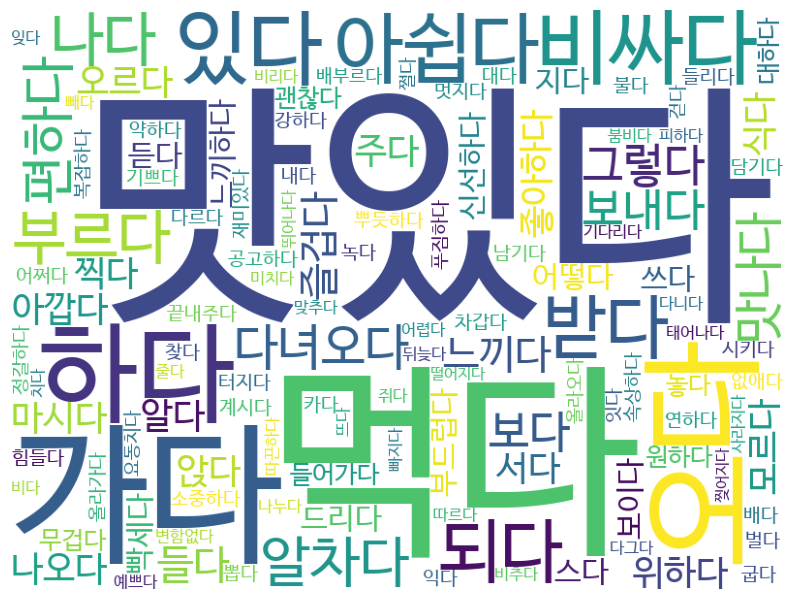

In [29]:
wordcloud_verb_adj(review_adj_verb)

- 문제점
    - `맛있-`,`좋-`,`친절-`등의 반복적인 얘기가 다른 형태로 나오게 되었다. => `Okt`로 형용사, 동사를 나누니 같은 `맛있-`, `좋-`등의 겹치는 것을 분류를 못한다.

- 해결방법
    - `kiwipiepy`패키지를 쓰니 해결되었다.

- 맛있다, 먹다등의 단어들이 많이 분포해있고 그뒤로 아쉽다, 비싸다라는 단어들이 분포되어 있는 것을 확인할 수 있다.

---

### 프롬프트 작성

In [36]:
import os
import pandas as pd
import json
from dotenv import load_dotenv

load_dotenv()

True

In [37]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()